In [3]:
%load_ext autoreload
%autoreload 2

In [21]:
import numpy as np
from scipy import interpolate

from matplotlib import rc, rcParams
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import matplotlib.tri as tri

import pathos.multiprocessing as mp
from pathos.multiprocessing import ProcessingPool as Pool

from functools import partial

from particle import *
from particle import literals as lp

from HNL_MC import *
from HNL_MC import hnl_tools
from HNL_MC.const import *
from HNL_MC.plot_style import *

In [8]:
UMU4 = np.sqrt(1e-4)
my_hnl = model.hnl_model(m4=0.150, mixings=[0.0,UMU4, 0.0])
my_hnl.set_high_level_variables()
my_hnl.compute_rates()

In [9]:
rates.nui_nuj_e_e_dipole(my_hnl,1)/rates.nui_nuj_gamma_dipole(my_hnl,1)

/usr/local/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


362499103634290.75

In [152]:
# grid of mix vs mass
gridx = 500
gridy = 500

M4 = np.logspace(np.log10(0.01), np.log10(0.388), gridx)
USQR = np.logspace(-12,-2, gridy) 
X,Y = np.meshgrid(M4,USQR)
m4_grid, usqr_grid = X.flatten(), Y.flatten()

# run event rate calc ß
tot_cores = mp.cpu_count()
pool = Pool(tot_cores)
############


ctaudipole = pool.map(get_ctau0_dipole, ((m4, usqr) for m4, usqr in zip(m4_grid, usqr_grid)))
ctauZ = pool.map(get_ctau0_Z, ((m4, usqr) for m4, usqr in zip(m4_grid, usqr_grid)))

############
pool.terminate()
pool.restart()

<multiprocess.pool.Pool state=RUN pool_size=8>

In [153]:
gamma_nu_e_e_dipole(0.1,1,cut_ee=0.05)/gamma_nu_gamma_dipole(0.1, 1)

0.013760750075401285

In [154]:
print(f'{ratio_of_lifetimes(0.1,1e-2,1e-7):.2g}')

2e+02


In [155]:
def gamma_nu_gamma_dipole(mn,dipole):
    return mn**3*dipole**2/4/np.pi

def gamma_nu_e_e_dipole(mh,dipole,cut_ee=2*m_e):
    reemin = cut_ee/mh
    r = m_e/mh
    gamma=1/18 * alphaQED * ( dipole )**( 2 ) * ( mh )**( 3 ) * ( np.pi )**( -2 ) * ( reemin )**( -2 ) * ( ( -1 + ( reemin )**( 2 ) ) * ( -18 * ( r )**( 2 ) * ( -2 + ( 3 * ( reemin )**( 2 ) + ( reemin )**( 4 ) ) ) + ( reemin )**( 2 ) * ( 5 + ( 14 * ( reemin )**( 2 ) + 5 * ( reemin )**( 4 ) ) ) ) + 24 * ( -2 + 3 * ( r )**( 2 ) ) * ( reemin )**( 2 ) * np.log( reemin ) )
    return gamma

def gamma_Z(mh,U2):
    return mh**5*U2*Gf**2/192/np.pi**3


In [180]:
get_ctau0_Z((1,2))

0.22723462892142865

In [157]:
def ratio_of_lifetimes(MN,U2,dipole):
    return (gamma_nu_gamma_dipole(MN,dipole)+gamma_nu_e_e_dipole(MN,dipole))/(gamma_Z(MN,U2)*1.9)

def get_ctau0_dipole(arg):
    MN,dipole = arg
    def gamma_nu_gamma_dipole(mn,dipole):
        return mn**3*dipole**2/4/np.pi

    def gamma_nu_e_e_dipole(mh,dipole,cut_ee=2*m_e):
        reemin = cut_ee/mh
        r = m_e/mh
        gamma=1/18 * alphaQED * ( dipole )**( 2 ) * ( mh )**( 3 ) * ( np.pi )**( -2 ) * ( reemin )**( -2 ) * ( ( -1 + ( reemin )**( 2 ) ) * ( -18 * ( r )**( 2 ) * ( -2 + ( 3 * ( reemin )**( 2 ) + ( reemin )**( 4 ) ) ) + ( reemin )**( 2 ) * ( 5 + ( 14 * ( reemin )**( 2 ) + 5 * ( reemin )**( 4 ) ) ) ) + 24 * ( -2 + 3 * ( r )**( 2 ) ) * ( reemin )**( 2 ) * np.log( reemin ) )
        return gamma

    def gamma_Z(mh,U2):
        return mh**5*U2*Gf**2/192/np.pi**3

    return get_decay_rate_in_cm(gamma_nu_gamma_dipole(MN,dipole)+gamma_nu_e_e_dipole(MN,dipole)+1.9*gamma_Z(MN,dipole))

def get_ctau0_Z(arg):
    MN,dipole = arg
    def gamma_nu_gamma_dipole(mn,dipole):
        return mn**3*dipole**2/4/np.pi

    def gamma_nu_e_e_dipole(mh,dipole,cut_ee=2*m_e):
        reemin = cut_ee/mh
        r = m_e/mh
        gamma=1/18 * alphaQED * ( dipole )**( 2 ) * ( mh )**( 3 ) * ( np.pi )**( -2 ) * ( reemin )**( -2 ) * ( ( -1 + ( reemin )**( 2 ) ) * ( -18 * ( r )**( 2 ) * ( -2 + ( 3 * ( reemin )**( 2 ) + ( reemin )**( 4 ) ) ) + ( reemin )**( 2 ) * ( 5 + ( 14 * ( reemin )**( 2 ) + 5 * ( reemin )**( 4 ) ) ) ) + 24 * ( -2 + 3 * ( r )**( 2 ) ) * ( reemin )**( 2 ) * np.log( reemin ) )
        return gamma

    def gamma_Z(mh,U2):
        return mh**5*U2*Gf**2/192/np.pi**3

    return get_decay_rate_in_cm(1.9*gamma_Z(MN,dipole))

def ratio_of_rates(MN,U2,dipole):
    return gamma_nu_e_e_dipole(MN,dipole)/gamma_Z(MN,U2)


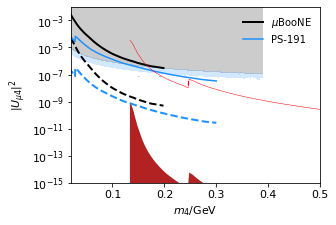

In [179]:
dij = 1e-7
fig = plt.figure()
ax = fig.add_axes(axes_form)
ax.patch.set_facecolor('None')

# Kelly Machado 
mbound,ubound = np.genfromtxt('digitized/muboone_kelly_machado/PS_eff_scalar.dat',unpack=True)
plt.plot(mbound/1e3,ubound, c='black', lw=2, ls='-', label='$\mu$BooNE')
plt.plot(mbound/1e3,ubound/np.sqrt(ratio_of_rates(mbound/1e3,ubound, dij)), c='black', lw=2, ls='--')
# plt.plot(mbound/1e3,1e-2/ratio_of_lifetimes(mbound/1e3,ubound, dij), c='black', lw=2, ls=':', label='$\mu$BooNE + $d$')

# mbound,ubound = np.genfromtxt('digitized/muboone_kelly_machado/PS_eff_avg.dat',unpack=True)
# plt.plot(mbound/1e3,ubound, c='green', lw=2, ls='--', label='Kelly \& Machado')


## PS191
x = np.logspace(np.log10(10),np.log10(300), 1000, endpoint=True)

this_file = 'Nlimits/digitized/PS-191/UeUmu_K.dat'
m4, Umu4sq = np.genfromtxt(this_file, unpack=True)
fK = interpolate.interp1d(m4, Umu4sq, kind='linear', bounds_error=False, fill_value=1, assume_sorted=False)    
this_file = 'Nlimits/digitized/PS-191/UeUmu_pi.dat'
m4, Umu4sq = np.genfromtxt(this_file, unpack=True)
fpi = interpolate.interp1d(m4, Umu4sq, kind='linear', bounds_error=False, fill_value=1, assume_sorted=False)    
gL = -1/2 + 0.223
gR = 0.22343
scaling = np.sqrt(gL**2 +gR**2 + gR*gL)
combined = np.amin([fK(x),fpi(x)],axis=0)
NBAKGS = 30
lower_line = combined/scaling
sqrtN_line = combined/scaling*np.sqrt(np.sqrt(NBAKGS)/2.3)
N_line = combined/scaling*np.sqrt(np.sqrt(NBAKGS**2)/2.3)

units = 1e-3
ax.plot(x*units, lower_line, color='dodgerblue', ls='-', label=fr'PS-191')

plt.plot(x*units,lower_line/np.sqrt(ratio_of_rates(x*units,lower_line, dij)), c='dodgerblue', lw=2, ls='--')
# plt.plot(x*units,1e-2/(ratio_of_lifetimes(x*units,lower_line,dij)), c='dodgerblue', lw=2, ls='--', label='PS-191 + $d$')

mbound,ubound = np.genfromtxt('digitized/Boyarsky_et_al/BBN_Umu4_lower_bound.dat',unpack=True)
plt.fill_between(mbound,ubound/ratio_of_lifetimes(mbound,ubound,dij), 0*ubound, fc='firebrick')
plt.plot(mbound,ubound, c='red',lw=0.5)


# lifetime curves 
# Xi,Yi,Zi=interp_grid(x=m4_grid, y=usqr_grid , z=ctauZ, fine_gridx=gridx, fine_gridy=gridy, log=True)
# level_0 = ax.contour(Xi, Yi, Zi, levels = [280e2], colors=['gold']) #NEW CONSTRAINT

Xi,Yi,Zi=interp_grid(x=m4_grid, y=usqr_grid , z=ctaudipole, fine_gridx=gridx, fine_gridy=gridy, log=True)
level_0 = ax.contourf(Xi, Yi, Zi, levels = [0,128e2/40,400e2/20], colors=['black','dodgerblue'], alpha=0.2) #NEW CONSTRAINT
# level_0 = ax.contour(m4_grid, usqr_grid, ctaudipole, levels = [280e2/40], colors=['gold']) #NEW CONSTRAINT


# x=np.logspace(-2,1,100)
# mnu=0.05e-9
# plt.plot(x, mnu/x)

ax.set_yscale("log")
# ax.set_xscale("log")

ax.set_ylabel("$|U_{\mu 4}|^2$")
ax.set_xlabel("$m_4/$GeV")

ax.legend(loc='upper right', frameon=False, ncol=1)
ax.set_ylim(1e-15,1e-2)
ax.set_xlim(2e-2,0.5)
fig.savefig('plots/T2K_bound.png',dpi=400)